<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на

1.   List item
2.   List item

то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
def get_dataloader(image_size, batch_size, data_dir):
    """
    Builds dataloader for training data.
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :param data_dir: directory containing the dataset
    :returns: DataLoader object
    """
    transformations = tt.Compose([
        tt.Resize((image_size, image_size)),
        tt.ToTensor(),
        tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

    ])

    dataset = ImageFolder(root=data_dir, transform=transformations)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


In [3]:
# !ls -la ../input/archive-gan/faces_dataset_small

!gdown --id '1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x' -O 'archive.zip'
!unzip -q 'archive.zip' -d './archive'

In [4]:
image_size = 128
batch_size = 6 # 12

data_dir = '../input/archive-gan/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = get_dataloader(image_size, batch_size, data_dir)



## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [5]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # 5x5
            nn.Sigmoid()
        )

        self.fc = nn.Linear(1 * 5 * 5, 1)

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)




In [6]:
latent_size = 128  

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(latent_size, 256 * 8 * 8)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  
        )

    def forward(self, x):
        x = x.view(-1, latent_size)
        x = self.fc(x)
        x = x.view(x.size(0), 256, 8, 8)
        return self.main(x)



Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [7]:
lr = 0.0001 #0.00005

generator = Generator(latent_size).to(device)
discriminator = Discriminator().to(device)

criterion = nn.MSELoss() # nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr/2000)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


model = {
    "discriminator": discriminator,
    "generator": generator
}

optimizer = {
    "discriminator": optimizer_discriminator,
    "generator": optimizer_generator
}

In [8]:
def fit(model, criterion, epochs, lr, dataloader, device):
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            real_labels = (0.7 - 0.9) * torch.rand(batch_size, device=device) + 0.9
            fake_labels = (0.1 - 0.3) * torch.rand(batch_size, device=device) + 0.1

            # Изменение формы целевых меток
            real_labels = real_labels.view(-1, 1)
            fake_labels = fake_labels.view(-1, 1)

            model['discriminator'].zero_grad()

            outputs = model['discriminator'](real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model['generator'](noise)

            outputs = model['discriminator'](fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            optimizer_discriminator.step()

            model['generator'].zero_grad()

            outputs = model['discriminator'](fake_images)
            g_loss = criterion(outputs, real_labels)  # Здесь real_labels уже изменены
            g_loss.backward()

            optimizer_generator.step()

            d_losses.append(d_loss_real.item() + d_loss_fake.item())
            g_losses.append(g_loss.item())

        print(f'Эпоха [{epoch + 1}/{epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item():.4f}, g_loss: {g_loss.item():.4f}')

    return d_losses, g_losses



Эпоха [1/200], d_loss: 1.7896, g_loss: 0.0315
Эпоха [2/200], d_loss: 1.6271, g_loss: 0.0034
Эпоха [3/200], d_loss: 1.5451, g_loss: 0.0007
Эпоха [4/200], d_loss: 1.5921, g_loss: 0.0034
Эпоха [5/200], d_loss: 1.6040, g_loss: 0.0017
Эпоха [6/200], d_loss: 1.4845, g_loss: 0.0031
Эпоха [7/200], d_loss: 1.2375, g_loss: 0.0045
Эпоха [8/200], d_loss: 1.2504, g_loss: 0.0068
Эпоха [9/200], d_loss: 1.2960, g_loss: 0.0094
Эпоха [10/200], d_loss: 1.2364, g_loss: 0.0019
Эпоха [11/200], d_loss: 1.2790, g_loss: 0.0046
Эпоха [12/200], d_loss: 1.2030, g_loss: 0.0046
Эпоха [13/200], d_loss: 1.0501, g_loss: 0.0042
Эпоха [14/200], d_loss: 1.2044, g_loss: 0.0014
Эпоха [15/200], d_loss: 1.1576, g_loss: 0.0016
Эпоха [16/200], d_loss: 1.2421, g_loss: 0.0031
Эпоха [17/200], d_loss: 1.2309, g_loss: 0.0067
Эпоха [18/200], d_loss: 1.0462, g_loss: 0.0029
Эпоха [19/200], d_loss: 1.0929, g_loss: 0.0056
Эпоха [20/200], d_loss: 1.0883, g_loss: 0.0045
Эпоха [21/200], d_loss: 1.1194, g_loss: 0.0070
Эпоха [22/200], d_loss

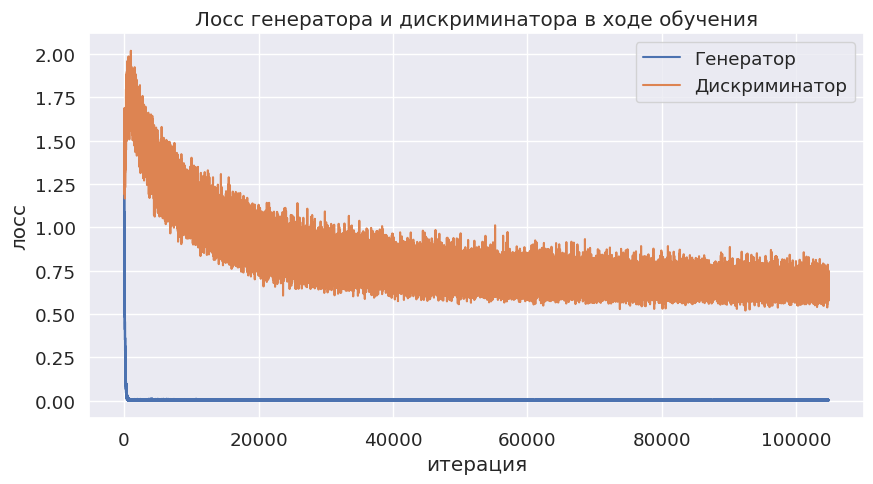

In [9]:
epochs = 200

d_losses, g_losses = fit(model, nn.MSELoss() , epochs, lr, dataloader, device) # nn.BCELoss()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Лосс генератора и дискриминатора в ходе обучения")
plt.plot(g_losses,label="Генератор")
plt.plot(d_losses,label="Дискриминатор")
plt.xlabel("итерация")
plt.ylabel("лосс")
plt.legend()
plt.show()


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

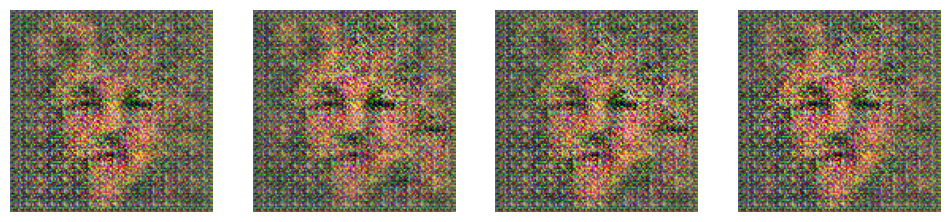

In [10]:
def show_images(generated):
    images_np = generated.cpu().detach().numpy()
    
    images_np = images_np.transpose((0, 2, 3, 1))
    
    images_np = (images_np * 0.5) + 0.5  
    
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 3, 3))
    for img, ax in zip(images_np, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

n_images = 4
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

show_images(fake_images)


Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: